<a href="https://colab.research.google.com/github/a-pujahari/EVA7/blob/main/Session8/EVA7_AssignmentS8_Patience2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EVA 7 - Assignment 8

## Submission by Abhinav Pujahari (abhinavpujahari@gmail.com)

## Goals:
1. Modularize code further by creating individual folders for models, utilities (training, testing, helper functions etc), containing generalized callable functions.
2. Upload modularized code to GitHub - to be used for all future assignments
3. Train ResNet18 model on CIFAR10 dataset for 40 epochs:
    * Use albumentations transforms/augmentations of RandomCrop, CutOut and Rotate
    * Use ReduceLROnPlateau as learning rate scheduler
    * Use Layer Normalization
4. Show gradcam outputs for 20 misclassified images

## Import Dependencies

In [2]:
## Install Dependencies
!pip install albumentations==0.4.6
!pip install torchsummary

     |████████████████████████████████| 117 kB 15.9 MB/s 
     |████████████████████████████████| 948 kB 50.0 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65172 sha256=d39888c3c73f4649a51e4adad62f12620868b8d7104695be71551158971401d4
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [6]:
## Clone Deep Learning Utils Repo
!git clone https://github.com/a-pujahari/Torch_CV_Utils.git

Cloning into 'Torch_CV_Utils'...
remote: Enumerating objects: 55, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 55 (delta 22), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (55/55), done.


In [2]:
from Torch_CV_Utils import main
from Torch_CV_Utils.utils import data_handling, train, test, gradcam, helpers, augmentation
from Torch_CV_Utils.models import resnet
from pprint import pprint

## Import Config

In [17]:
config_file_path = "/content/Torch_CV_Utils/config/config.yaml"

config = helpers.load_config_variables(config_file_path)
pprint(config)

 loading Configuration of your experiment ..
{'L2_penalty': 1e-05,
 'coarseDropoutProb': 0.5,
 'grayscaleProb': 0.15,
 'horizontalFlipProb': 0.2,
 'maxHeight': 16,
 'maxHoles': 1,
 'maxWidth': 16,
 'minHeight': 16,
 'minHoles': 1,
 'minWidth': 16,
 'momentum_val': 0.9,
 'padHeightWidth': 40,
 'randomCropProb': 1,
 'randomCropSize': 32,
 'rotateLimit': 5,
 'scaleLimit': 0.1,
 'sch_reduceLR_cooldown': 0,
 'sch_reduceLR_eps': 1e-08,
 'sch_reduceLR_factor': 0.1,
 'sch_reduceLR_min_lr': 0,
 'sch_reduceLR_mode': 'min',
 'sch_reduceLR_patience': 2,
 'sch_reduceLR_threshold': 0.0001,
 'sch_reduceLR_threshold_mode': 'abs',
 'shiftLimit': 0.1,
 'shiftScaleRotateProb': 0.25,
 'standard_lr': 0.01}


## Perform GPU Check; Create "Device"

In [18]:
device, cuda = helpers.gpu_check(seed_value = 1)
pprint(device)

CUDA is available
device(type='cuda')


## Download Dataset, Create Data Loaders

In [5]:
mean, std = data_handling.return_dataset_statistics()
trainloader, testloader = main.create_dataloaders(mean, std, cuda, config, augment_func = "albumentation_augmentation_S8")

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## Model Summary

In [19]:
from torchsummary import summary
model = resnet.ResNet18("layer").to(device)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
         GroupNorm-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
         GroupNorm-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
         GroupNorm-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
         GroupNorm-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
        GroupNorm-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
        GroupNorm-14          [-1, 128,

## Trigger Training

In [20]:
train_acc, train_losses, test_acc, test_losses, lrs = main.trigger_training(model, device, trainloader, testloader, config, optimizer_name = "Adam", scheduler_name = "ReduceLROnPlateau", criterion_name = "CrossEntropyLoss", lambda_l1 = 0, epochs = 40)

EPOCH: 1


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=1.8496730327606201 Batch_id=390 LR=0.01000 Accuracy=20.47: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 0.0144, Accuracy: 3471/10000 (34.71%)

EPOCH: 2


Loss=1.700940728187561 Batch_id=390 LR=0.01000 Accuracy=37.52: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 0.0119, Accuracy: 4395/10000 (43.95%)

EPOCH: 3


Loss=1.4075685739517212 Batch_id=390 LR=0.01000 Accuracy=44.36: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 0.0106, Accuracy: 5053/10000 (50.53%)

EPOCH: 4


Loss=1.308881163597107 Batch_id=390 LR=0.01000 Accuracy=50.78: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 0.0097, Accuracy: 5554/10000 (55.54%)

EPOCH: 5


Loss=1.195965051651001 Batch_id=390 LR=0.01000 Accuracy=56.33: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]



Test set: Average loss: 0.0087, Accuracy: 6059/10000 (60.59%)

EPOCH: 6


Loss=0.9262809753417969 Batch_id=390 LR=0.01000 Accuracy=61.13: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 0.0076, Accuracy: 6545/10000 (65.45%)

EPOCH: 7


Loss=0.7600483894348145 Batch_id=390 LR=0.01000 Accuracy=64.29: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 0.0075, Accuracy: 6733/10000 (67.33%)

EPOCH: 8


Loss=0.9105936288833618 Batch_id=390 LR=0.01000 Accuracy=67.09: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]



Test set: Average loss: 0.0066, Accuracy: 7054/10000 (70.54%)

EPOCH: 9


Loss=0.8120039701461792 Batch_id=390 LR=0.01000 Accuracy=69.42: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 0.0064, Accuracy: 7167/10000 (71.67%)

EPOCH: 10


Loss=0.7472900152206421 Batch_id=390 LR=0.01000 Accuracy=71.39: 100%|██████████| 391/391 [00:40<00:00,  9.77it/s]



Test set: Average loss: 0.0064, Accuracy: 7182/10000 (71.82%)

EPOCH: 11


Loss=0.8741633296012878 Batch_id=390 LR=0.01000 Accuracy=72.86: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]



Test set: Average loss: 0.0057, Accuracy: 7452/10000 (74.52%)

EPOCH: 12


Loss=0.7175939679145813 Batch_id=390 LR=0.01000 Accuracy=74.36: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]



Test set: Average loss: 0.0053, Accuracy: 7650/10000 (76.50%)

EPOCH: 13


Loss=0.8295496106147766 Batch_id=390 LR=0.01000 Accuracy=75.54: 100%|██████████| 391/391 [00:39<00:00,  9.78it/s]



Test set: Average loss: 0.0059, Accuracy: 7425/10000 (74.25%)

EPOCH: 14


Loss=0.6007490754127502 Batch_id=390 LR=0.01000 Accuracy=76.63: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0055, Accuracy: 7630/10000 (76.30%)

EPOCH: 15


Loss=0.6348546147346497 Batch_id=390 LR=0.01000 Accuracy=77.15: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 0.0050, Accuracy: 7796/10000 (77.96%)

EPOCH: 16


Loss=0.49253812432289124 Batch_id=390 LR=0.01000 Accuracy=78.27: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 0.0053, Accuracy: 7733/10000 (77.33%)

EPOCH: 17


Loss=0.5814189314842224 Batch_id=390 LR=0.01000 Accuracy=78.29: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 0.0047, Accuracy: 7972/10000 (79.72%)

EPOCH: 18


Loss=0.7026769518852234 Batch_id=390 LR=0.01000 Accuracy=78.90: 100%|██████████| 391/391 [00:40<00:00,  9.74it/s]



Test set: Average loss: 0.0053, Accuracy: 7797/10000 (77.97%)

EPOCH: 19


Loss=0.41823309659957886 Batch_id=390 LR=0.01000 Accuracy=79.60: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0047, Accuracy: 7951/10000 (79.51%)

EPOCH: 20


Loss=0.4998660981655121 Batch_id=390 LR=0.01000 Accuracy=79.87: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 0.0045, Accuracy: 8109/10000 (81.09%)

EPOCH: 21


Loss=0.5047949552536011 Batch_id=390 LR=0.01000 Accuracy=80.21: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 0.0047, Accuracy: 7977/10000 (79.77%)

EPOCH: 22


Loss=0.4607629179954529 Batch_id=390 LR=0.01000 Accuracy=80.43: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0045, Accuracy: 8038/10000 (80.38%)

EPOCH: 23


Loss=0.5254514813423157 Batch_id=390 LR=0.01000 Accuracy=81.28: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0046, Accuracy: 8055/10000 (80.55%)

EPOCH: 24


Loss=0.3120506703853607 Batch_id=390 LR=0.00100 Accuracy=85.26: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 0.0037, Accuracy: 8382/10000 (83.82%)

EPOCH: 25


Loss=0.4767836630344391 Batch_id=390 LR=0.00100 Accuracy=86.28: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 0.0037, Accuracy: 8401/10000 (84.01%)

EPOCH: 26


Loss=0.27029430866241455 Batch_id=390 LR=0.00100 Accuracy=86.83: 100%|██████████| 391/391 [00:40<00:00,  9.75it/s]



Test set: Average loss: 0.0037, Accuracy: 8417/10000 (84.17%)

EPOCH: 27


Loss=0.34874287247657776 Batch_id=390 LR=0.00100 Accuracy=86.99: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0037, Accuracy: 8438/10000 (84.38%)

EPOCH: 28


Loss=0.2744261920452118 Batch_id=390 LR=0.00010 Accuracy=87.47: 100%|██████████| 391/391 [00:40<00:00,  9.72it/s]



Test set: Average loss: 0.0036, Accuracy: 8459/10000 (84.59%)

EPOCH: 29


Loss=0.36675572395324707 Batch_id=390 LR=0.00010 Accuracy=87.72: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0036, Accuracy: 8466/10000 (84.66%)

EPOCH: 30


Loss=0.3088639974594116 Batch_id=390 LR=0.00010 Accuracy=87.84: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 0.0035, Accuracy: 8487/10000 (84.87%)

EPOCH: 31


Loss=0.4108864367008209 Batch_id=390 LR=0.00010 Accuracy=87.92: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0035, Accuracy: 8476/10000 (84.76%)

EPOCH: 32


Loss=0.336304634809494 Batch_id=390 LR=0.00001 Accuracy=88.02: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]



Test set: Average loss: 0.0036, Accuracy: 8477/10000 (84.77%)

EPOCH: 33


Loss=0.28174060583114624 Batch_id=390 LR=0.00001 Accuracy=87.94: 100%|██████████| 391/391 [00:40<00:00,  9.73it/s]



Test set: Average loss: 0.0036, Accuracy: 8479/10000 (84.79%)

EPOCH: 34


Loss=0.34737858176231384 Batch_id=390 LR=0.00001 Accuracy=88.06: 100%|██████████| 391/391 [00:39<00:00,  9.79it/s]



Test set: Average loss: 0.0035, Accuracy: 8476/10000 (84.76%)

EPOCH: 35


Loss=0.31638404726982117 Batch_id=390 LR=0.00000 Accuracy=88.23: 100%|██████████| 391/391 [00:40<00:00,  9.76it/s]



Test set: Average loss: 0.0036, Accuracy: 8476/10000 (84.76%)

EPOCH: 36


Loss=0.26791971921920776 Batch_id=390 LR=0.00000 Accuracy=88.20: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 0.0036, Accuracy: 8478/10000 (84.78%)

EPOCH: 37


Loss=0.33553794026374817 Batch_id=390 LR=0.00000 Accuracy=88.17: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 0.0036, Accuracy: 8479/10000 (84.79%)

EPOCH: 38


Loss=0.41764649748802185 Batch_id=390 LR=0.00000 Accuracy=88.01: 100%|██████████| 391/391 [00:39<00:00,  9.81it/s]



Test set: Average loss: 0.0036, Accuracy: 8479/10000 (84.79%)

EPOCH: 39


Loss=0.3543129563331604 Batch_id=390 LR=0.00000 Accuracy=87.84: 100%|██████████| 391/391 [00:40<00:00,  9.70it/s]



Test set: Average loss: 0.0035, Accuracy: 8479/10000 (84.79%)

EPOCH: 40


Loss=0.41575154662132263 Batch_id=390 LR=0.00000 Accuracy=88.11: 100%|██████████| 391/391 [00:39<00:00,  9.80it/s]



Test set: Average loss: 0.0035, Accuracy: 8479/10000 (84.79%)



## Plot Metrics

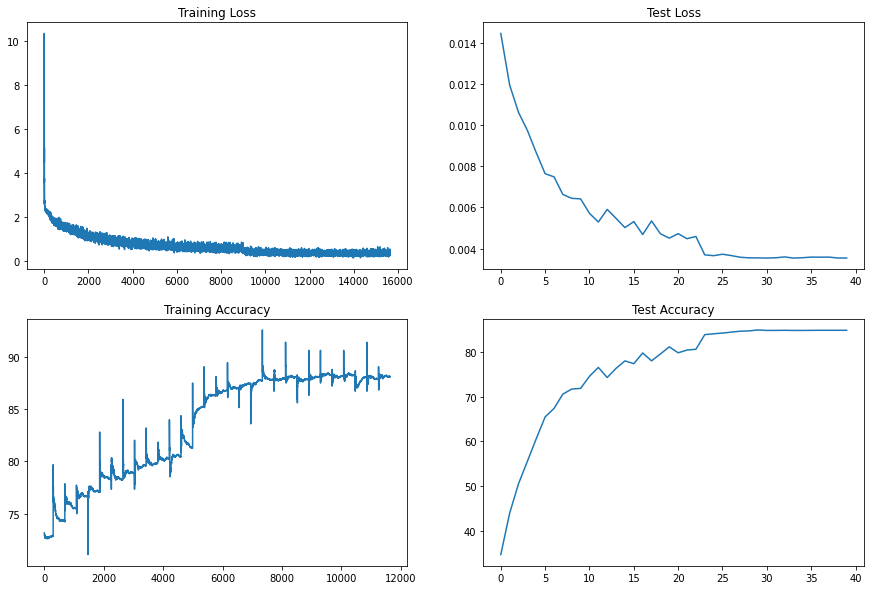

In [21]:
helpers.plot_metrics(train_acc, train_losses, test_acc, test_losses)

## Misclassified Images

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Total wrong predictions are 1867


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


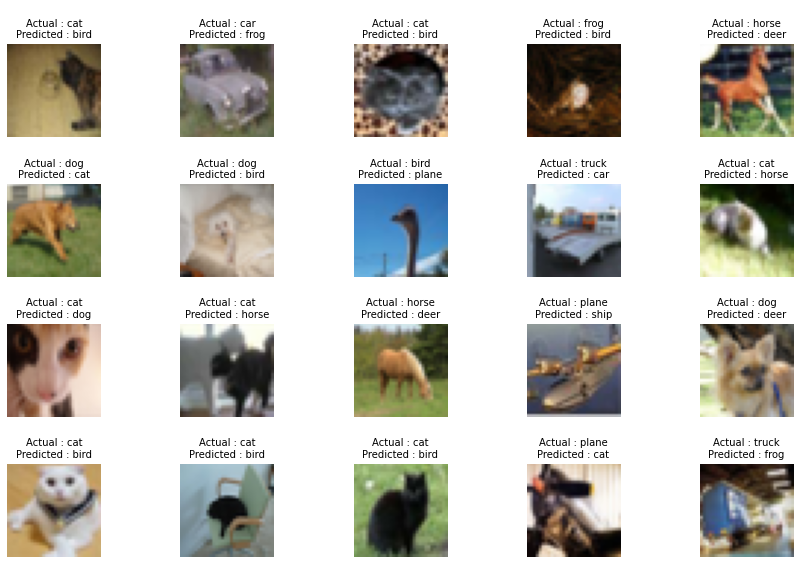

In [14]:
misclassified_images = helpers.wrong_predictions(model, testloader, device)
helpers.plot_misclassified(misclassified_images, mean, std, 20)

## Gradcam

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM @layer4


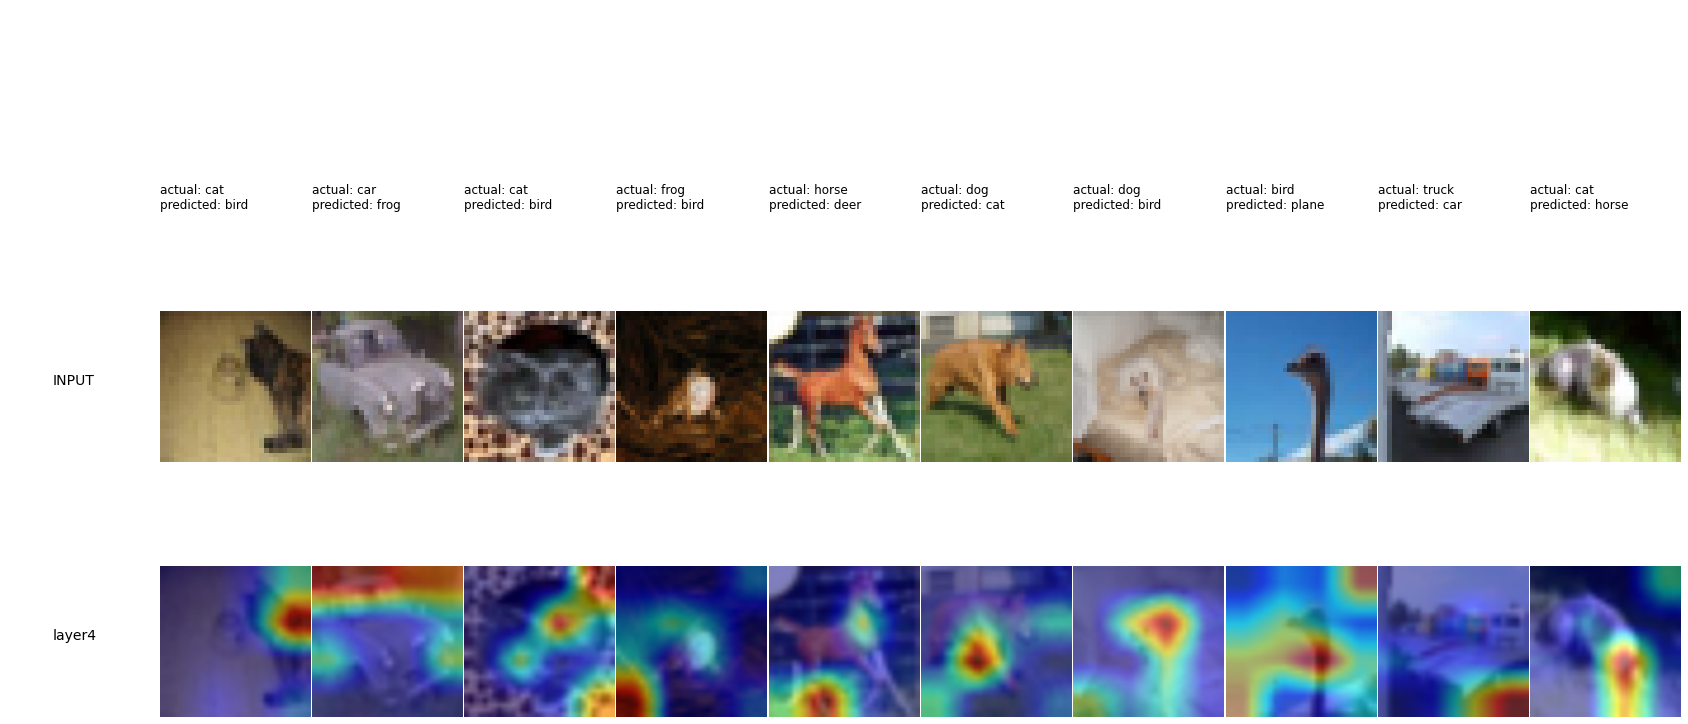

In [15]:
target_layers = ["layer4"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[:10], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[:10], mean, std)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1025: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Generating Grad-CAM @layer4


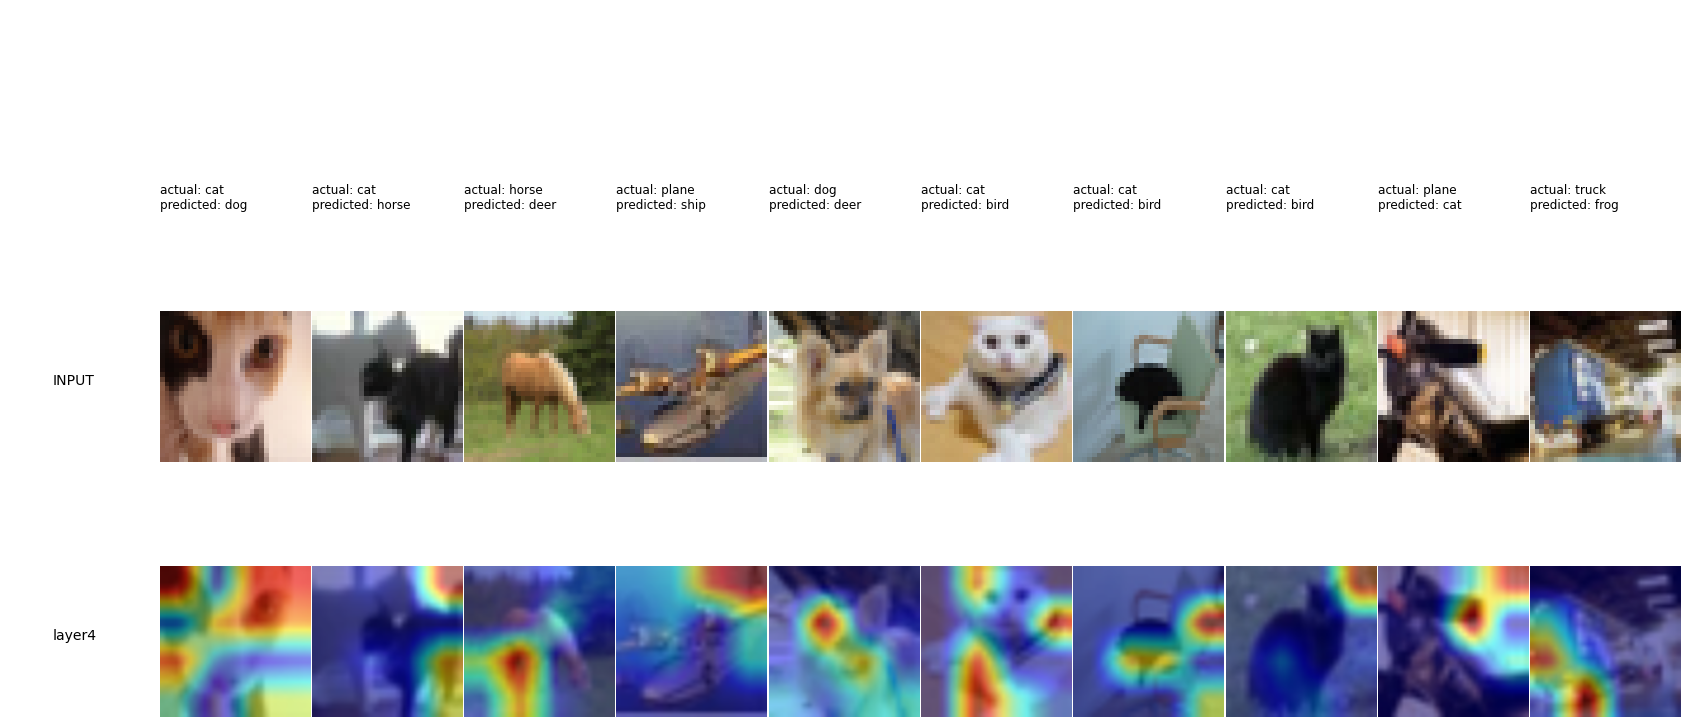

In [16]:
target_layers = ["layer4"]
classes = ('plane', 'car', 'bird', 'cat','deer', 'dog', 'frog', 'horse', 'ship', 'truck')
gradcam_output, probs, predicted_classes = gradcam.generate_gradcam(misclassified_images[10:20], model, target_layers, device)
gradcam.plot_gradcam(gradcam_output, target_layers, classes, (3, 32, 32),predicted_classes, misclassified_images[10:20], mean, std)